In [1]:
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, scale
import seaborn as sns
from pyearth import Earth
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pp = pprint.PrettyPrinter()

import TraitData
from imp import reload
from permutation_analysis import Permutation

In [2]:
AVOID_LONG_COMPUTATIONS = False
SCORING = 'neg_mean_squared_error'

<img style="float:right" src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" width=60px)/>
# Traits and Range Shifts: Parameter Optimization +  Feature Engineering

## <small>work by [Tony Cannistra](http://www.github.com/acannistra) and the [Buckley Lab](http://faculty.washington.edu/lbuckley) at the University of Washington</small>

In experimentation with several regression techniques aiming to harness the predictive value of physiological traits, two techniques proved best: Multivariate Adaptive Regression Splines (MARS) and Support Vector regression (SVR). 

We hone the predictions of those two methods for this application by performing two optmizations: grid parameter search and feature engineering. 


### Contents
1. [Grid Search Background](#Grid-Search-Background)
1. [MARS Grid Search](#MARS)
1. [SVR Parameter Grid Search](#)
1. [Feature Engineering](#Feature-Engineering)

## Grid Search Background

Many algorithms have a large number of hyperparameters which can be tuned to improve performance. Often the pursuit of the optimal hyperparameters is arduous, especially when there are a large number of them (or a large hyperparameter space). 

Scikit-Learn provides two functions for hyperparameter search: [`model_selection.GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) and [`model_selection.RandomizedSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). `GridSearchCV` provides an exhaustive search over parameter values and uses cross-validation and a scoring function to evaluate the most optimal parameters from the space given. `RandomizedSearchCV` samples candidate parameter values from given distributions. 

We evaluate the resulting models by using a holdout dataset. 



---


In [3]:
Data = {} ## master dictionary containing all data transformations

responseVar = "migration_m"

plants_master = pd.read_csv("../data/plants5.csv")


drop_features = ["Taxon",
                 "migr_sterr_m", 
                 "shift + 2SE", 
                 'signif_shift',
                 "signif_shift2",
                 "dispmode01",
                 "DispModeEng", ## what is this
                 "shift + 2SE",
                ]

categorical_features = ["oceanity",
                        "dispersal_mode",
                        "BreedSysCode",
                        "Grime"]

##
# We leave the data as-is, with missing values and categorical variables.
##

# plants = pd.get_dummies(plants_master, columns=categorical_features)

# # drop features we don't want
# features = plants.drop(drop_features, axis=1)

# # drop features with n/a or NaN
# ## axis = 1 drops columns with any NAs, axis = 0 drops rows with any NAs
# features.dropna(axis=1, inplace=True)

# # extract and remove target variable
# target   = features[responseVar]
# features.drop([responseVar], inplace=True, axis=1)

# X, x_test, Y, y_test = train_test_split(features, target, test_size=0.30)

# print("Features: ",X.columns.values)
# print("Examples:", len(X))
reload(TraitData)
td = TraitData.TraitData("../data/plants5.csv",
               responseVar,
               drop_features,
               categorical_features,
               dropNA=1)

X, x_test, Y, y_test = td.train_test_split(0.30)

## MARS
[mars]: http://www.jstor.org/stable/2241837?origin=JSTOR-pdf&seq=1#page_scan_tab_contents "Friedman 2001"
[leathwick]: http://www.web.stanford.edu/~hastie/Papers/Ecology/fwb_1448.pdf "Leathwick et al. 2005"
The multivariate adaptive regression splines approach [(Friedman 2001)][mars] fits piece-wise linear basis functions in order to better approximate nonlinear realtionships. It has limited uses in ecology, with the first published example in [Leathwick et al. 2005][leathwick]. It offers our best bet for a bencmark that has any hope of capturing these nonlinear relationships.

### Benchmarking 
Nothing fancy, how does the algorithm perform with base parameters?

In [6]:
mars = Earth()

## this is a long computation
if not AVOID_LONG_COMPUTATIONS:
    print(-cross_val_score(mars, X, Y, cv=LeaveOneOut(), scoring=SCORING, n_jobs=-1).mean())
else:
    print("Long computations disabled.")


20.9437728685


In [9]:
if not AVOID_LONG_COMPUTATIONS:
    print(-cross_val_score(mars, X, Y, cv=KFold(2), scoring=SCORING, n_jobs=-1).mean())
else:   
    print("Long computations disabled.")

23.6535623406


## Permutation Testing

In [ ]:
def loo_cv_eval(model, features, target):
	return -cross_val_score(model, features, target, cv=LeaveOneOut(), scoring=SCORING, n_jobs=1).mean()

permuter = Permutation(mars, X, Y, loo_cv_eval)
permuter.execute_test(n_tests=1000, threads=20)
sns.distplot(permuter.results)

/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklear

In [278]:
criteria = ('rss', 'gcv', 'nb_subsets')

mars = Earth(max_degree=3, feature_importance_type=criteria)
mars.fit(features, target)

if not AVOID_LONG_COMPUTATIONS:
    print(-cross_val_score(mars, features, target, cv=LeaveOneOut(), scoring=SCORING, n_jobs=-1).mean())
else:
    print("Long computations disabled.")

45.5871283592


## SVR

### Benchmarking

In [5]:
from sklearn.svm import SVR


base = SVR()
errs = cross_val_score(base, scale(X), Y, cv=LeaveOneOut(), scoring=SCORING, n_jobs=-1)
-errs.mean()


21.775398037383017

Pretty good. Let's see if we can do better. 

### Parameter Grid Search

In [280]:
print("SVM Parameters:\n ", str(list(base.get_params().keys())))


SVM Parameters:
  ['kernel', 'verbose', 'C', 'gamma', 'coef0', 'epsilon', 'cache_size', 'degree', 'tol', 'shrinking', 'max_iter']


In [6]:
params_grid = {
    'C'     :  np.logspace(-3, 3, 13), 
    'gamma' : np.logspace(-3, 3, 13),
}

SVR_grid = GridSearchCV(base,
                        param_grid = params_grid,
                        scoring=SCORING,
                        n_jobs = -1,
                        error_score = 0,
                        cv=KFold(5)) 

SVR_grid.fit(scale(X), Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score=0,
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'gamma': array([  1.00000e-03,   3.16228e-03,   1.00000e-02,   3.16228e-02,
         1.00000e-01,   3.16228e-01,   1.00000e+00,   3.16228e+00,
         1.00000e+01,   3.16228e+01,   1.00000e+02,   3.16228e+02,
         1.00000e+03]), 'C': array([  1.00000e-03,   3.16228e-03,   1.00000e-02,   3.16228e-02,
         1.00000e-01,   3.16228e-01,   1.00000e+00,   3.16228e+00,
         1.00000e+01,   3.16228e+01,   1.00000e+02,   3.16228e+02,
         1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [7]:
best = SVR_grid.best_estimator_
pp.pprint(best.get_params())
pp.pprint(base.get_params())

{'C': 31.622776601683793,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 1.0,
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}
{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [309]:
print("Base MSE on test:", cross_val_score(base, scale(x_test), y_test, scoring='neg_mean_squared_error').mean())

print("Best MSE on test:", cross_val_score(best, scale(x_test), y_test, scoring='neg_mean_squared_error').mean())




Base MSE on test: -21.3151848986
Best MSE on test: -20.1796969166


## Neural Network Parameter Optimisation


In [9]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor()

errs = cross_val_score(nn, scale(X), Y, cv=LeaveOneOut(), scoring=SCORING, n_jobs=-1)
print("Base error: ", -errs.mean())

/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Base error:  31.7211630802


In [10]:
param_grid = {
    'hidden_layer_sizes' : [[100,100], [100, 100, 100], [50, 50]],
    'activation' : ['relu', 'logistic'],
    'solver' : ['adam', 'lbfgs'],
    'alpha' : [0.0001, 0.001, 0.01, 1],
    'learning_rate' : ['adaptive', 'constant']
}

nn_grid  = GridSearchCV(nn,
                        param_grid = param_grid,
                        scoring=SCORING,
                        n_jobs = -1,
                        error_score = 0,
                        cv=KFold(5)) 

nn_grid.fit(scale(X), Y)

/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score=0,
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 1], 'solver': ['adam', 'lbfgs'], 'hidden_layer_sizes': [[100, 100], [100, 100, 100], [50, 50]], 'activation': ['relu', 'logistic'], 'learning_rate': ['adaptive', 'constant']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [11]:
nn_grid.best_params_

{'activation': 'logistic',
 'alpha': 0.001,
 'hidden_layer_sizes': [100, 100],
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [14]:
print("Base MSE on test:", cross_val_score(nn, scale(x_test), y_test, scoring='neg_mean_squared_error').mean())

print("Best MSE on test:", cross_val_score(nn_grid.best_estimator_, scale(x_test), y_test, scoring='neg_mean_squared_error').mean())

/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Base MSE on test: -30.2898459242


/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Best MSE on test: -23.6061501081


/opt/conda/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [ ]:

def evaluation_function(model, features, target):
	return -cross_val_score(model, features, target, cv=KFold(5), scoring=SCORING, n_jobs=1).mean()
bestModel = nn_grid.best_estimator_
permTester = Permutation(bestModel, td.X, td.Y, evaluation_function)
permTester.execute_test(n_tests=500, threads=50)

/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/opt/conda/lib/python3.5/site-packages/sklear

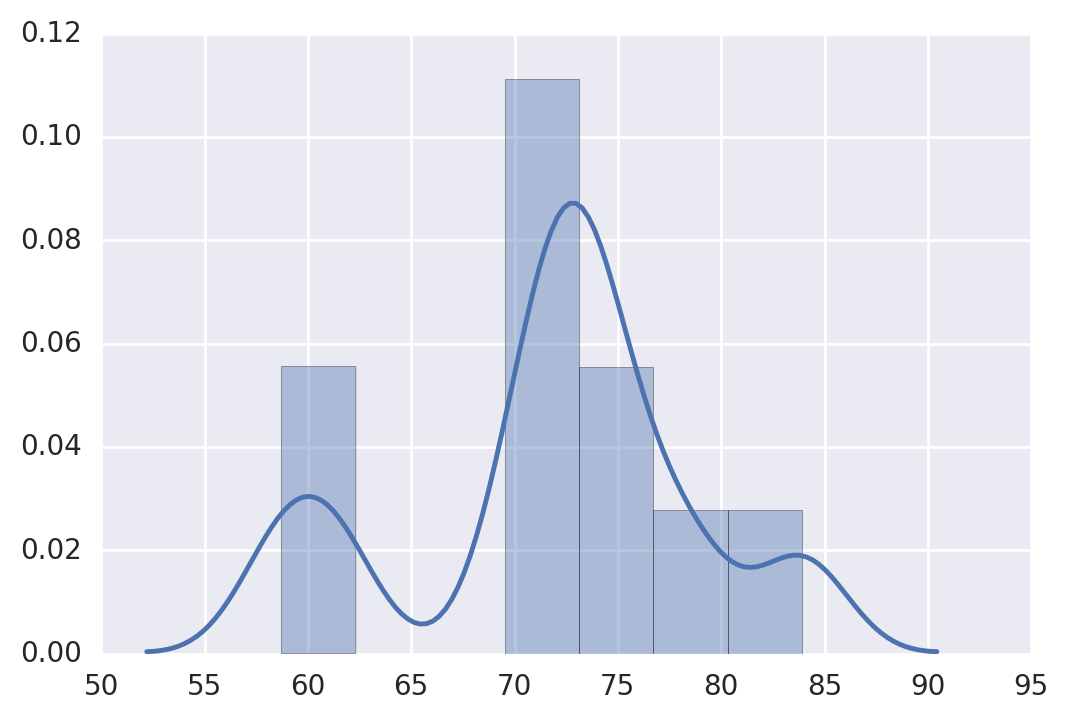

In [17]:
sns.distplot(permTester.results)

---

[featEng]: http://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/ "Source"

## Feature Engineering
> Feature engineering is the process of transforming raw data into features that better represent the underlying problem to the predictive models, resulting in improved model accuracy on unseen data. [source] [featEng]

This applies to our problem in several ways. The most straightforward work in feature engineering we've already done most of. Namely, the encoding of categorical features in a way that creates binary features for each category of each categorical feature. This is known as *one hot* encoding. 


A much more interesting approach to feature engineering is the creation of new features by linearly combining existing features in some way. 

The challenge there is that creating pairwise multiples of, say, 20 features leads us to move from 20 features to 400 features. Learning any model on these 400 features is sure to lead to overfitting, especially in a linear model. We can combat this with regularization. 

There are two interesting forms of regularization that we can use for this project: ridge regression and LASSO regression. 
